In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import chdir as cd
import time
import fiona
from datetime import date

C:\Users\uttar\AppData\Local\Temp\ipykernel_15468\2483259319.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# CBSA Data

In [2]:
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip')
US_states = US_states.to_crs('EPSG:9311')

# adding metropolitan/Micropolitan geometry & population data
MSA_geo_20 = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_cbsa.zip')
MSA_geo_20 = MSA_geo_20.to_crs('EPSG:9311')
MSA_geo_20.columns


cbsa_2_place_geocorr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\cbsa_2_place.csv', header=1, encoding='latin-1')

cbsa_2_place_geocorr['State code']  = cbsa_2_place_geocorr['State code'].astype(str).str.rjust(2,'0')
cbsa_2_place_geocorr['Place code']  = cbsa_2_place_geocorr['Place code'].astype(str).str.rjust(5,'0')
cbsa_2_place_geocorr['GEOID_place'] = cbsa_2_place_geocorr[['State code','Place code']].astype(str).agg(''.join, axis=1)
cbsa_2_place_geocorr['GEOID_cbsa']  = cbsa_2_place_geocorr['Core-based statistical area code'].astype(str)
cbsa_2_place_geocorr

cbsa_2_place = cbsa_2_place_geocorr[['GEOID_cbsa',  'cbsa20-to-place allocation factor', 'GEOID_place']]

# Adding commuting time for cbsa 
cbsa_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ACSST5Y2020.S0801-Data.csv')
cbsa_tt = cbsa_commute_time[['GEO_ID', 'NAME', 'S0801_C01_046E']] # taking the column with mean travel time
cbsa_tt = cbsa_tt.tail(-1).reset_index(drop = True)
cbsa_tt['GEOID_cbsa'] = cbsa_tt['GEO_ID'].str[9:]
cbsa_tt.rename({'S0801_C01_046E':'tt_2_work'}, axis =1, inplace = True)
cbsa_tt

cbsa_data = cbsa_2_place.merge(cbsa_tt[['GEOID_cbsa', 'tt_2_work']], on = 'GEOID_cbsa', how = 'outer')
cbsa_2_place.shape, cbsa_tt.shape, cbsa_data.shape


cbsa_data['tt_2_work'] = cbsa_data['tt_2_work'].astype(float)
df_cbsa = cbsa_data.groupby('GEOID_place').agg({'GEOID_cbsa': 'count',
                                      'cbsa20-to-place allocation factor': 'sum',
                                      'tt_2_work': 'max'}).reset_index()

In [3]:
# cbsa_data[cbsa_data['GEOID_place'].duplicated(keep = False)].sort_values(['GEOID_place']) #.nunique()

# Urbanized area data

In [4]:
# urban area from 2020 census definition to place area conversion from GeoCorr22
ua_2_place_geocorr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\UA_2_Place_populationweighted.csv', header=1, encoding='latin-1')
ua_2_place_geocorr['State code'] = ua_2_place_geocorr['State code'].astype(str).str.rjust(2,'0')
ua_2_place_geocorr['Place code'] = ua_2_place_geocorr['Place code'].astype(str).str.rjust(5,'0')
ua_2_place_geocorr['GEOID'] = ua_2_place_geocorr[['State code','Place code']].astype(str).agg(''.join, axis=1)
ua_2_place_geocorr['Urban area (2022)'] = ua_2_place_geocorr['Urban area (2022)'].astype(str).str.rjust(5,'0')
ua_2_place_geocorr['GEOID'].nunique()
ua_2_place_geocorr['Urban area (2022)'].nunique()
ua_2_place = ua_2_place_geocorr[['Urban area (2022)', 'Total population (2020 Census)', 'ua-to-place allocation factor', 'GEOID']]

# Population in urban area from GeoCorr2022
ua_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ua_population_20.csv', header=1, encoding='latin-1')
ua_population['Urban area (2022)'] = ua_population['Urban area (2022)'].astype(str).str.rjust(5,'0')

ua_population.shape, ua_2_place.shape

df_ua = ua_2_place.merge(ua_population[['Urban area (2022)', 'Total population (2020 Census)']], on = 'Urban area (2022)', how = 'outer')

df_ua.rename({'Total population (2020 Census)_x':'population_place',
             'Total population (2020 Census)_y':'population_ua'}, 
             axis =1, inplace = True)

df_ua_place_level = df_ua.groupby('GEOID').agg({'Urban area (2022)':'count',
                                                'population_place': 'sum',
                                                'ua-to-place allocation factor': ['min', 'max'],
                                                'population_ua':['min', 'max'],
                                               }).reset_index()

df_ua_place_level.columns = [c[0] + "_" + c[1] for c in df_ua_place_level.columns]

In [5]:
# df_ua_place_level.head(5)

# Place (city) data

In [6]:
'''
source: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
MTFCC: G4110 (incorporated place) and G4210 (census designated place)
PCICBSA: Current metropolitan or micropolitan statistical area principal city indicator
'''
# importing spatial data 
US_places =  gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_places = US_places.to_crs('EPSG:9311')
US_places['PCICBSA'].value_counts()
# dropping columns that will not be used in the anaysis
places_US = US_places.drop(['PLACEFP', 'PLACENS', 'NAME', 'LSAD', 'CLASSFP',
                            'PCINECTA','FUNCSTAT', 'AWATER', 'INTPTLAT', 
                            'INTPTLON', ], axis =1)

# importing housing density calculated from Census Tract level, weighted by no of housing units
df_weighted_density = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\weighted_housingUnits_for_places.csv')
df_weighted_density['GEOID'] = df_weighted_density['GEOID_place'].astype(str).str.rjust(7, '0')


# merging spatial data with dataframe
places_weighted_housing = places_US.merge(df_weighted_density[['GEOID', 'weighted_HU_density_sqmi']], 
                                          on = 'GEOID')
places_weighted_housing.shape, places_weighted_housing.columns

# importing current trend estimates and joining with geodataframe
mk_dataset = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv')
mk_dataset['GEOID'] = mk_dataset['GEO_ID'].str[9:]

mk_dataset.shape, places_US.shape, df_weighted_density.shape

# this dataframe contains spatial data, housing density and current trend
df_current_trend = places_weighted_housing.merge(mk_dataset[['P_20', 'label', 'density_km2', 'GEOID']], 
                                    on = 'GEOID', how = 'outer')

df_current_trend.columns, df_current_trend.isna().sum()

# # adding future trend forecasts from another dataframe
# expected_trend_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\expected_trend_2023-03-29.csv', index_col =0)
# expected_trend_df['GEOID'] = expected_trend_df['GEOID'].astype(str).str.rjust(7, '0')
# df_forecasted_trend = df_current_trend.merge(expected_trend_df[['GEOID', 'State', 'NAME10', 'expected_trend_1', 'expected_trend_2',
#                                                                    'expected_trend_3', 'expected_trend_4', 'expected_trend_5',]],
#                                                 on= 'GEOID', how = 'outer')

# =========================CHANGING THIS LINE TO THE NEW WEIGHTED FILE ==============================================
# expected_trend_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\forecasted_trend_both.csv', 
#                                 index_col =0, dtype = {'GEOID': str})

expected_trend_df = pd.read_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\future trend from SSP 2023-05-05.csv', 
                                index_col =0, dtype = {'GEOID': str, 'STATEFP': str})


# expected_trend_df['GEOID'] = expected_trend_df['GEOID'].astype(str).str.rjust(7, '0')
df_forecasted_trend = df_current_trend.merge(expected_trend_df[['GEOID', 'Pop_estimate', 'CensusPop_20',
                                                                'trend', 'future trend from SSP 1', 'future trend from SSP 2',
                                                                'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5', 
                                                                'REGION', 'DIVISION']],
                                                on= 'GEOID', how = 'outer')


In [7]:
# df_forecasted_trend  = df_forecasted_trend.merge(US_states[['REGION', 'DIVISION', 'STATEFP']], on = 'STATEFP')

# commute time for places form ACS
places_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S0801-Data.csv')
place_tt = places_commute_time[['GEO_ID', 'NAME', 'S0801_C01_046E', 'S0801_C01_048E', 'S0801_C01_049E', 'S0801_C01_050E', 'S0801_C01_051E']]
place_tt = place_tt.tail(-1).reset_index(drop = True)
place_tt['GEOID'] = place_tt['GEO_ID'].str[9:]
place_tt.rename({'S0801_C01_046E':'tt_2_work_place',
                 'S0801_C01_048E':'no_veh', 
                 'S0801_C01_049E':'veh_1',
                 'S0801_C01_050E':'veh_2', 
                 'S0801_C01_051E':'veh_3_or+'}, axis =1, inplace = True)

place_tt[['no_veh', 'veh_1', 'veh_2', 'veh_3_or+']]  = place_tt[['no_veh', 'veh_1', 'veh_2', 'veh_3_or+']] .apply(pd.to_numeric, errors='coerce')
place_tt['veh_2_or+'] = place_tt['veh_2'] + place_tt['veh_3_or+']
print(place_tt.columns)

df_with_trend_forecast = df_forecasted_trend.merge(place_tt[['GEOID', 'tt_2_work_place', 'no_veh','veh_1','veh_2_or+']], on = 'GEOID', how = 'left')
# df_with_trend_forecast.isna().sum()

C:\Users\uttar\AppData\Local\Temp\ipykernel_15468\1133953604.py:4: DtypeWarning: Columns (2,3,4,5,102,103,104,105,186,187,188,189,230,231,232,233,330,331,332,333,414,415,416,417,458,459,460,461,558,559,560,561,642,643,644,645) have mixed types. Specify dtype option on import or set low_memory=False.
  places_commute_time = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S0801-Data.csv')


Index(['GEO_ID', 'NAME', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2',
       'veh_3_or+', 'GEOID', 'veh_2_or+'],
      dtype='object')


# Merging CBSA data & Urbanized area data with Place data

In [8]:
df_0 = df_with_trend_forecast.merge(df_cbsa, left_on = 'GEOID', right_on = 'GEOID_place', how = 'outer')
# df_0 = df_0.merge(df_uac, left_on = 'GEOID', right_on = 'GEOID', how = 'outer')

df_0 = df_0.merge(df_ua_place_level, left_on = 'GEOID', right_on = 'GEOID_', how = 'outer')

In [9]:
# df_0.isna().sum()

In [10]:
df_0['tt_2_work_place'].replace(['N', '-'], np.nan, inplace= True)
df_0['tt_2_work_place'] = df_0['tt_2_work_place'].astype(float)

In [11]:
# df_0[['tt_2_work_place', 'tt_2_work']].isna().sum()

In [12]:
df_0.columns

Index(['STATEFP', 'GEOID', 'NAMELSAD', 'PCICBSA', 'MTFCC', 'ALAND', 'geometry',
       'weighted_HU_density_sqmi', 'P_20', 'label', 'density_km2',
       'Pop_estimate', 'CensusPop_20', 'trend', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 'REGION',
       'DIVISION', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2_or+',
       'GEOID_place', 'GEOID_cbsa', 'cbsa20-to-place allocation factor',
       'tt_2_work', 'GEOID_', 'Urban area (2022)_count',
       'population_place_sum', 'ua-to-place allocation factor_min',
       'ua-to-place allocation factor_max', 'population_ua_min',
       'population_ua_max'],
      dtype='object')

# Labeling places as URBAN < SUBURBAN < RURAL

In [13]:
new_col = 'city type'
area_factor = 'ua-to-place allocation factor_max'
msa_area_factor = 'cbsa20-to-place allocation factor'
ua_population = 'population_ua_max'
population = 'CensusPop_20'
housingUnit_density = 'weighted_HU_density_sqmi'
city_type = 'PCICBSA'
df = df_0.copy()
df[new_col] = " "

# DEFINING URBAN < SUBURBAN < RURAL BASED ON THE RULES OF THE FOLLOWING LINK
# Apply conditions for urban-suburban-rural
# source: https://bjs.ojp.gov/content/pub/pdf/cusrancvs.pdf
# Suburban and rural places will be further differentiated

for i in df.index:
    if df.loc[i,city_type] == 'Y':
        if (df.loc[i, ua_population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) & (df.loc[i, area_factor] > 0):
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'suburban'
            
    elif (df.loc[i,city_type] == 'N') & (df.loc[i, area_factor] > 0):
        if (df.loc[i, ua_population] >= 500000) & (df.loc[i, housingUnit_density] >= 4000):
            df.loc[i, new_col] = 'urban'
        else:
            if (df.loc[i, 'tt_2_work_place'] <= df.loc[i, 'tt_2_work']):
                df.loc[i, new_col] = 'suburban'
            else:
                df.loc[i, new_col] = 'periurban'
                
    elif (df.loc[i,city_type] == 'N') & (df.loc[i, area_factor] <= 0):
        if (df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
            df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'rural'          

    else:
        df.loc[i, new_col] = 'not enough data'
        


In [14]:
df.shape,  df['city type'].value_counts()#/df['city type'].value_counts().sum()
# df[df['PCICBSA'] == 'Y']['city type'].value_counts()/df[df['PCICBSA'] == 'Y']['city type'].value_counts().sum()

((31991, 37),
 rural              18592
 suburban            7030
 periurban           5874
 urban                324
 not enough data      171
 Name: city type, dtype: int64)

In [15]:
# # to check if the intersected areas fall inside the MSAs
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(25,18))
# US_states.plot(ax=ax, facecolor = 'lightsteelblue', edgecolor='black', linewidth=0.2, alpha = 0.4)
# MSA_geo_20[MSA_geo_20['LSAD']=='M1'].plot(ax=ax, alpha = 0.4, color = 'darksalmon')

# df.plot(ax= ax, column = 'city type', legend = True, legend_kwds={'loc': 'lower left'}, cmap = matplotlib.colors.ListedColormap(['grey', 'yellowgreen', 'darkgreen','gold','brown',])) 

# xlim = ([-2257388.37, 2695859.75]) 
# ylim = ([-2246944.04, 918095.9])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

In [16]:
income_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S1901-Data.csv')
income_df = income_df[['GEO_ID', 'NAME', 'S1901_C01_012E']]
income_df = income_df.tail(-1).reset_index(drop = True)
income_df['GEOID'] = income_df['GEO_ID'].str[9:]
income_df.rename({'S1901_C01_012E':'median_income'}, axis =1, inplace = True)
df = df.merge(income_df[['median_income', 'GEOID']], on = 'GEOID')

df['median_income'] = df['median_income'].replace('-', np.nan)
df['median_income'] = df['median_income'].replace('2,500-', '2499')
df['median_income'] = df['median_income'].replace('250,000+', '250001')
df['median_income'] = df['median_income'].astype(float)

C:\Users\uttar\AppData\Local\Temp\ipykernel_15468\496520291.py:1: DtypeWarning: Columns (2,3,4,5,66,67,68,69,130,131,132,133,194,195,196,197) have mixed types. Specify dtype option on import or set low_memory=False.
  income_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\PLACE data\ACSST5Y2020.S1901-Data.csv')


# Chart/graphs from analysis

In [17]:
# Replacing nan values in STATEFP with respective values from GEOID

df.loc[df['STATEFP'].isnull(),'STATEFP'] = df['GEOID'].str[:2]

# Replacing nan values in region with respective values for that region
df[df['REGION'].isnull()]['STATEFP'].unique()
# Northeast = []
Midwest = ['29', '46']
South = ['13', '21', '37', '40', '48', '54']
West = ['02', '04', '06', '08', '35', '49', '56'] 
        
df['REGION'] = np.where(df["STATEFP"].isin(Midwest), 2, df['REGION'])
df['REGION'] = np.where(df["STATEFP"].isin(South), 3, df['REGION'])
df['REGION'] = np.where(df["STATEFP"].isin(West), 4, df['REGION'])


In [18]:
for i in range(len(df)):
    # print(i)
    if df.loc[i,'REGION'] == 1:
        df.loc[i,'REGION'] = 'Northeast'
    elif df.loc[i,'REGION'] == 2:
        df.loc[i,'REGION'] = 'Midwest' 
    elif df.loc[i,'REGION'] == 3:
        df.loc[i,'REGION'] = 'South'
    elif df.loc[i,'REGION'] == 4:
        df.loc[i,'REGION'] = 'West'
    else:
        df.loc[i,'REGION'] = 'Outside Contiguous US'   

In [21]:
df['REGION'].value_counts()

31888

In [23]:
# df[df['REGION'] == 'Outside Contiguous US']

In [76]:
# # Group the data by the three categorical variables and sum the values
# trend_column = 'future trend from SSP 4'

# grouped_data1 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Northeast')].groupby(['city type',
#                                                                                                    trend_column ])[['GEOID']].count()
# # Convert the grouped data into a hierarchical structure
# hierarchical_data1 = grouped_data1.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# # Normalize the data
# normalized_data1 = hierarchical_data1.apply(lambda x: x/x.sum(), axis=1)

# grouped_data2 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Midwest')].groupby(['city type',
#                                                                                                    trend_column ])[['GEOID']].count()
# # Convert the grouped data into a hierarchical structure
# hierarchical_data2 = grouped_data2.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# # Normalize the data
# normalized_data2 = hierarchical_data2.apply(lambda x: x/x.sum(), axis=1)

# grouped_data3 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'South')].groupby(['city type',
#                                                                                                    trend_column ])[['GEOID']].count()
# # Convert the grouped data into a hierarchical structure
# hierarchical_data3 = grouped_data3.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# # Normalize the data
# normalized_data3 = hierarchical_data3.apply(lambda x: x/x.sum(), axis=1)

# grouped_data4 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'West')].groupby(['city type',
#                                                                                                    trend_column ])[['GEOID']].count()
# # Convert the grouped data into a hierarchical structure
# hierarchical_data4 = grouped_data4.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# # Normalize the data
# normalized_data4 = hierarchical_data4.apply(lambda x: x/x.sum(), axis=1)


# fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
# fig.suptitle('Percent cities for different community type and Regions with their future trend for SSP 4',)

# sns.set(font_scale = 1)
# # Bulbasaur
# sns.heatmap(normalized_data1, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[0] , cbar_ax=None)
# axes[0].set_title('Northeast')

# sns.heatmap(normalized_data2, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[1] ,)
# axes[1].set_title('Midwest')
# axes[1].set_ylabel('')

# sns.heatmap(normalized_data3, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[2] , )
# axes[2].set_title('South')
# axes[2].set_ylabel('')

# sns.heatmap(normalized_data4, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[3] , )
# axes[3].set_title('West')
# axes[3].set_ylabel('')

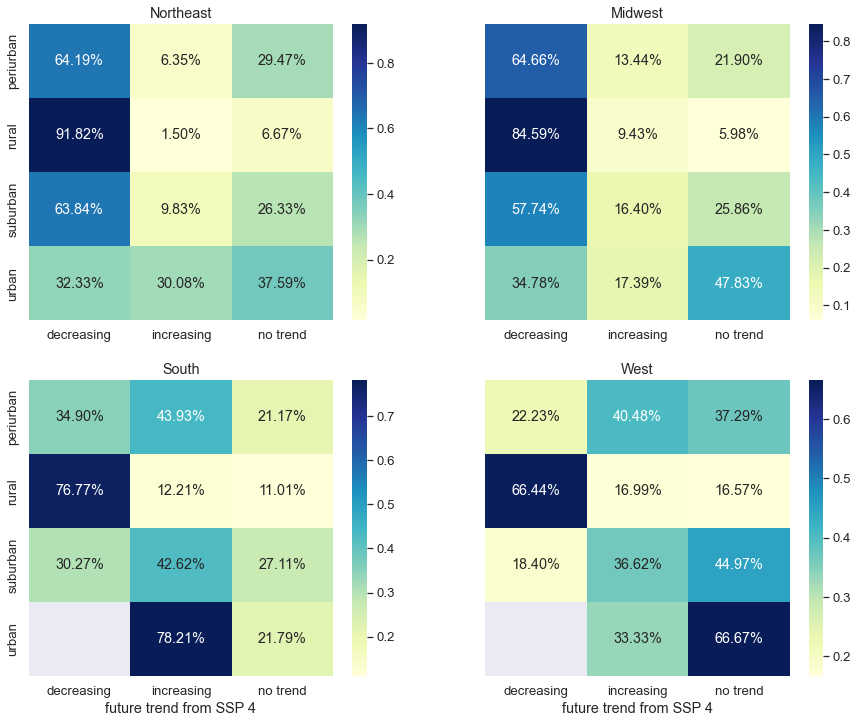

In [74]:
# Group the data by the three categorical variables and sum the values
trend_column = 'future trend from SSP 4'

grouped_data1 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Northeast')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data1 = grouped_data1.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data1 = hierarchical_data1.apply(lambda x: x/x.sum(), axis=1)

grouped_data2 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Midwest')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data2 = grouped_data2.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data2 = hierarchical_data2.apply(lambda x: x/x.sum(), axis=1)

grouped_data3 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'South')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data3 = grouped_data3.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data3 = hierarchical_data3.apply(lambda x: x/x.sum(), axis=1)

grouped_data4 = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'West')].groupby(['city type',
                                                                                                   trend_column ])[['GEOID']].count()
# Convert the grouped data into a hierarchical structure
hierarchical_data4 = grouped_data4.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)
# Normalize the data
normalized_data4 = hierarchical_data4.apply(lambda x: x/x.sum(), axis=1)


fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
# fig.suptitle('Percent cities for different community type and Regions with their expected trend from SSP 2',)
sns.set(font_scale = 1.2)
# Bulbasaur
sns.heatmap(normalized_data1, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[0][0] , cbar_ax=None)
axes[0][0].set_title('Northeast')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('')


sns.heatmap(normalized_data2, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[0][1] ,)
axes[0][1].set_title('Midwest')
axes[0][1].set_ylabel('')
axes[0][1].set_xlabel('')


sns.heatmap(normalized_data3, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[1][0] , )
axes[1][0].set_title('South')
axes[1][0].set_ylabel('')

sns.heatmap(normalized_data4, annot=True, fmt='.2%', cmap='YlGnBu', ax= axes[1][1] , )
axes[1][1].set_title('West')
axes[1][1].set_ylabel('')

fig.savefig('D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\Trend with DoU_' + str(trend_column) + '.png', 
            dpi = 300, bbox_inches='tight')

In [26]:
# Group the data by the three categorical variables and sum the values
# trend_column = 'trend_SSP_2'
# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'West')]
# grouped_data = df_plot.groupby(['city type', trend_column ])[['GEOID']].count()

# # Convert the grouped data into a hierarchical structure
# hierarchical_data = grouped_data.pivot_table(values='GEOID', index=['city type', ], columns=trend_column ,)

# # Normalize the data
# normalized_data = hierarchical_data.apply(lambda x: x/x.sum(), axis=1)

# # Plot the heatmap
# fig, ax = plt.subplots(figsize=(10,6))
# sns.heatmap(normalized_data, annot=True, fmt='.2%', cmap='YlGnBu')
# ax.set_title('Percent cities for different community type with their expected trend for West')
# plt.show()

In [27]:
# df[['geometry','GEOID']].__geo_interface__

In [28]:
# df.columns
# gdf = df[['GEOID', 'city type']]
# gf1 = df[['geometry','GEOID',]]
# jsonfile = json.loads(gdf1.to_json())
# df.isna().sum()

In [29]:
# df_data.dtypes, gdf_plot.dtypes
# df[(df['STATEFP'] == '48') | (df['STATEFP'] == '04')]
# df_data

In [30]:
# # Import the necessaries libraries
# import plotly
# import plotly.graph_objs as go
# import plotly.io as pio
# pio.renderers.default = 'iframe'
# # Set notebook mode to work in offline
# plotly.offline.init_notebook_mode(connected=True)

# df_plot = df.to_crs('EPSG:4326')
# df_data =df_plot[['GEOID','NAMELSAD', 'weighted_HU_density_sqmi', 'P_20', 'density_km2_x', 
#                                        'tt_2_work_place','median_income',
#                                        'label', 'future trend from SSP 2', 'future trend from SSP 3', 
#                                        'city type',]]

# # df_data = pd.DataFrame({'GEOID': df_plot['GEOID'].tolist(),
# #                         'city type': df_plot['city type'].tolist(),
# #                         'tt_2_work_place': df_plot['tt_2_work_place'].tolist(),
# #                         'P_20': df_plot['P_20'].tolist(),
# #                         'future trend from SSP 3': df_plot['future trend from SSP 3'].tolist(),
# #                         })

# gdf_plot = df_plot[['geometry','GEOID']]

In [31]:
# fig=px.choropleth_mapbox(df_data,
#                          geojson=gdf_plot.__geo_interface__,
#                          featureidkey='properties.GEOID',   
#                          locations='GEOID',        #column in dataframe
#                          # animation_frame='Year',       #dataframe
#                          color='city type',  #dataframe
#                          hover_name = 'NAMELSAD',
#                          # hover_data = ['GEOID','weighted_HU_density_sqmi', 'P_20', 'density_km2', 
#                          #               'tt_2_work_place','median_income',
#                          #               'label', 'future trend from SSP 2', 'future trend from SSP 3', 
#                          #               'city type', ],
#                          # color_continuous_scale='Inferno',
#                          # projection="mercator",
#                          color_continuous_scale="deep",
#                          mapbox_style="carto-positron",
#                          zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
#                          title='Population trend', 
#                          opacity=0.5,
#                          labels={'city type':'Community type'},
#                          height=700,
#                         )
# # fig.update_geos(fitbounds="locations", visible=False)
# # fig.show()
# plotly.offline.plot(fig, filename='US_urban_rural-chart.html')
# # fig.write_html("output.html", include_plotlyjs='cdn')

In [32]:
# from dash import Dash, dcc, html
# import plotly.express as px
# from base64 import b64encode
# import io

# app = Dash(__name__)

# buffer = io.StringIO()

# fig=px.choropleth_mapbox(df_data,
#                          geojson=gdf_plot.__geo_interface__,
#                          featureidkey='properties.GEOID',   
#                          locations='GEOID',        #column in dataframe
#                          # animation_frame='Year',       #dataframe
#                          color='city type',  #dataframe
#                          hover_name = 'NAMELSAD',
#                          # hover_data = ['GEOID','weighted_HU_density_sqmi', 'P_20', 'density_km2', 
#                          #               'tt_2_work_place','median_income',
#                          #               'label', 'future trend from SSP 2', 'future trend from SSP 3', 
#                          #               'city type', ],
#                          # color_continuous_scale='Inferno',
#                          # projection="mercator",
#                          color_continuous_scale="deep",
#                          mapbox_style="carto-positron",
#                          zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
#                          title='Population trend', 
#                          opacity=0.5,
#                          labels={'city type':'Community type'},
#                          height=700,
#                         )
# fig.write_html(buffer)

# html_bytes = buffer.getvalue().encode()
# encoded = b64encode(html_bytes).decode()

# app.layout = html.Div([
#     html.H4('Simple plot export options'),
#     html.P("↓↓↓ try downloading the plot as PNG ↓↓↓", style={"text-align": "right", "font-weight": "bold"}),
#     dcc.Graph(id="graph", figure=fig),
#     html.A(
#         html.Button("Download as HTML"), 
#         id="download",
#         href="data:text/html;base64," + encoded,
#         download="plotly_graph.html"
#     )
# ])


# app.run_server(debug=True)


In [33]:
# from plotly.subplots import make_subplots
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# fig = make_subplots(rows=1, cols=5)

# trend_column = 'future trend from SSP 3'
# landuse_category = df['city type'].sort_values().unique()

# for i, cat in enumerate(landuse_category):
#     fig = px.sunburst(df[df['city type'] == cat].groupby(['city type', 'REGION', trend_column]).size().to_frame(name = 'No of cities').reset_index(),
#                   path=['city type', 'REGION', trend_column], values='No of cities',
#                   color = trend_column,
#                   color_discrete_map={'urban':'brown', 'decreasing':'maroon', 'no trend':'goldenrod', 'increasing':'green'},
#                   # row=1, col= i+1
#                   # color_continuous_scale='RdBu',
#                   )
#     fig.show()
    
    
# for k in range(len(distplfig.data)):
#     fig.add_trace(distplfig.data[k],
#     row=2, col=2
# )
# fig.update_layout(barmode='overlay')
# plotly.offline.plot(fig, filename='test.html')
# #fig.show()

In [34]:
# # checking data distribution
# # plot for current trend and landuse
# df_crosstab = pd.crosstab(index=df.REGION, 
#                           columns=[df['city type'], df['label'], ],
#                           normalize= 'index')  # {‘all’, ‘index’, ‘columns’},
# df_crosstab

# # color_names = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray']
# # ['salmon', 'darkgoldenrod', 'greenyellow', 'tomato', 'goldenrod', 'yellowgreen', 'darksalmon', 'gold', 'palegreen', 'coral', 'tan', 'lightgreen']

# ax = df_crosstab.plot(
#     kind = 'barh',
#     stacked = True,
#     color = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray'],
#     # title = '% Cities with population trend',
#     mark_right = True,
#     figsize=(12, 6))

# # setting label sizes after creation
# ax.yaxis.label.set_size(15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 12})
# plt.tight_layout()
# plt.show()
# fig = ax.get_figure()

# #################################################################################
# # # plot for future trend and landuse
# df_crosstab = pd.crosstab(index=df['REGION'], 
#                           columns=[df['future trend from SSP 3'], 
#                                    df['city type']],
#                           normalize= 'index')

# ax = df_crosstab.plot(
#     kind = 'barh',
#     stacked = True,
#     color = ['tomato', 'indianred', 'coral', 'greenyellow', 'yellowgreen', 'palegreen', 'goldenrod',  'gold', 'tan'],
#     # title = '% Cities with population trend',
#     mark_right = True,
#     figsize=(10, 4))

# # setting label sizes after creation
# ax.yaxis.label.set_size(12)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 12})
# plt.tight_layout()
# plt.show()
# fig = ax.get_figure()

In [35]:
# (df.groupby(['REGION', 'city type', 'future trend from SSP 3'])['city type'].count() *100 / df.groupby(['REGION','city type', 'future trend from SSP 3'])['city type'].count().sum())

In [36]:
# sns.set_palette("Set2", 7)
# g = sns.FacetGrid(df.sort_values('future trend from SSP 3'), col="label", col_wrap=7)
# g.map_dataframe(sns.scatterplot, 'density_km2', "weighted_HU_density_sqmi", hue="city type",)
# g.add_legend()

In [37]:
crosstabRes = pd.crosstab(index = df['city type'], columns = df['label'])
from scipy.stats import chi2_contingency
chisqRes =  chi2_contingency(crosstabRes)
print('P-value of the chi- squared test: ', chisqRes[1])
if chisqRes[1] < 0.05:
    print('The variables have correlation.')
else:
    print('not correlated')

P-value of the chi- squared test:  0.0
The variables have correlation.


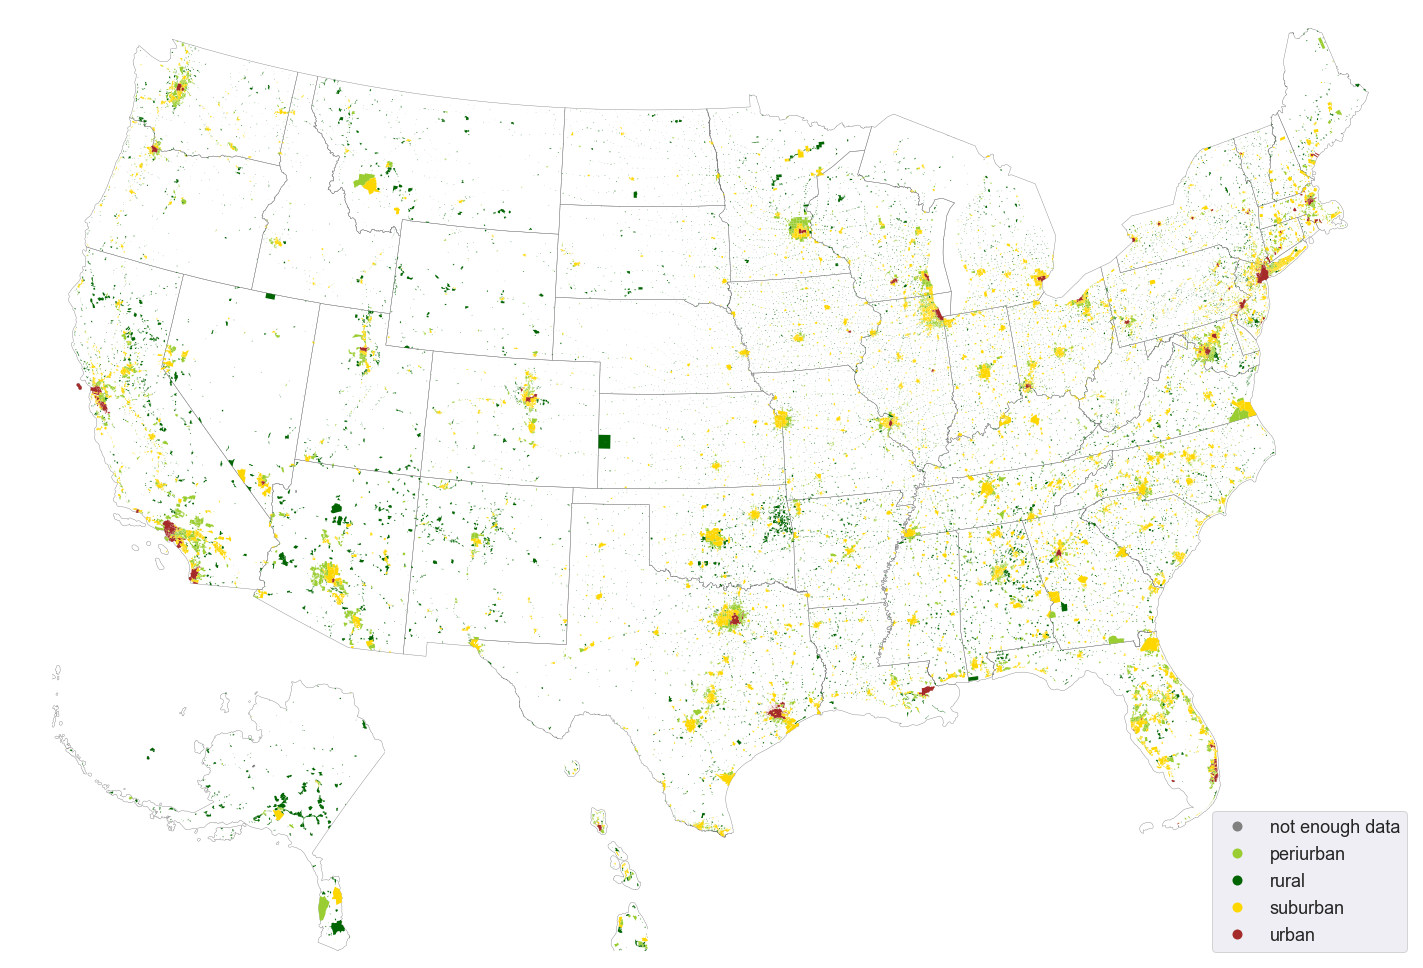

In [38]:
col = "city type"
cmap_color = matplotlib.colors.ListedColormap(['grey', 'yellowgreen', 'darkgreen','gold','brown',])

fig, continental_ax = plt.subplots(figsize=(20, 20))
alaska_ax = continental_ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = continental_ax.inset_axes([.30, .01, .25, .20])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)

alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)   # bounds found for only populated places in Hawaii
hawaii_ax.set_ylim(-1044618.58269969, -455238.37803499)

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
#vmin, vmax = df['ALAND'].agg(['min', 'max'])
US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
df.plot(column=col, 
        ax=continental_ax,
        cmap=cmap_color,
        edgecolor = 'None',
        alpha = 1,
        legend = True,
        legend_kwds={'loc': 'lower right', 'fontsize': 18,}) #, vmin=vmin, vmax=vmax)

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=alaska_ax)
df.plot(column=col, cmap=cmap_color, edgecolor = 'None', ax=alaska_ax) #, vmin=vmin, vmax=vmax)
US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=hawaii_ax)
df.plot(column=col, cmap=cmap_color, edgecolor = 'None', ax=hawaii_ax) #, vmin=vmin, vmax=vmax)

# continental_ax.set_title('TITLE', fontsize=15, pad=5) 
#from ACS 5-yr population estimates using data from 2010-2020, (b) 

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.axis('off') 
        
fig.patch.set_visible(False)
    
    
fig.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\urban_rural_continuum' + '.png', dpi = 300,
           bbox_inches='tight')

In [39]:
# MSA_geo_20.crs, df.crs
# df[(df['STATEFP'] == '11') | (df['STATEFP'] == '24') | (df['STATEFP'] == '51')][['GEOID','PCICBSA', 'NAMELSAD','weighted_HU_density_sqmi', 'P_20', 
#                                     'tt_2_work_place', 'tt_2_work', 'ua-to-place allocation factor_max', 'population_ua_max', 
#                                     'city type']].sort_values(['city type', 'weighted_HU_density_sqmi']).tail(22)

"\nFrom Rishabh's paper:\nZIP codes with a housing density ---------\nabove 2,213 households per square mile are classified as urban, \nthose between 102 to 2,213 households per square mile as suburban, and \nthose with fewer than 102 households per square mile as rural. \n"

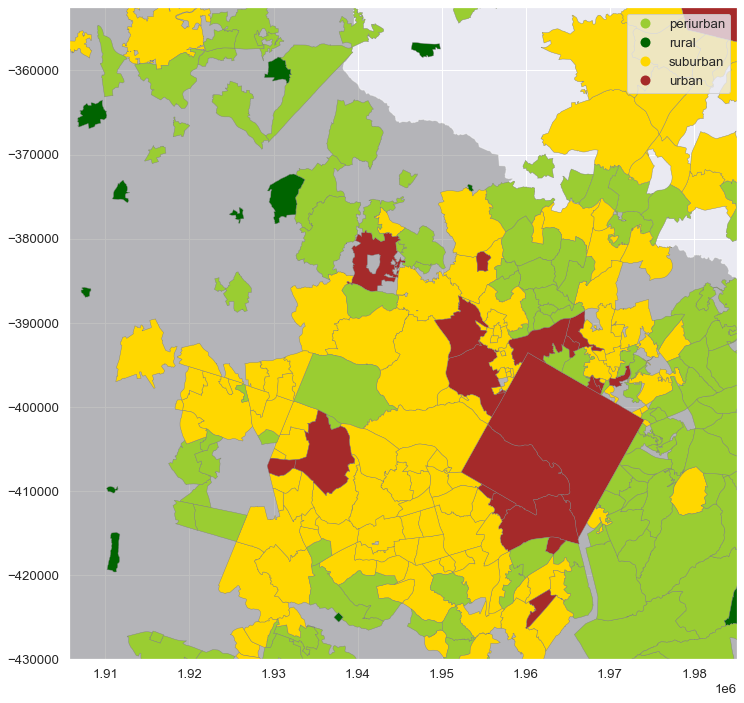

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,12))
cmap_color = matplotlib.colors.ListedColormap(['yellowgreen', 'darkgreen','gold','brown',])
MSA_geo_20[MSA_geo_20['NAMELSAD'].str.contains('DC')].plot(ax=ax, alpha = 0.5, color = 'gray') # [MSA_data_20['LSAD']=='M1']
df[(df['STATEFP'] == '11') | (df['STATEFP'] == '24') | (df['STATEFP'] == '51')].plot(ax= ax, cmap=cmap_color, column  = 'city type', 
                                                                                     edgecolor='gray', linewidth=0.4, legend = True)
xlim = ([1905651.2601596, 1985109.28733622]) 
ylim = ([-430006.06386062,-352453.50247821])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

'''
From Rishabh's paper:
ZIP codes with a housing density ---------
above 2,213 households per square mile are classified as urban, 
those between 102 to 2,213 households per square mile as suburban, and 
those with fewer than 102 households per square mile as rural. 
'''

# Median income vs REGION > Landuse > Trend

In [41]:
# df[df['city type'] != 'not enough data'].groupby(['REGION', 'city type','future trend from SSP 3'])[['median_income']].describe()

In [42]:
df.columns

Index(['STATEFP', 'GEOID', 'NAMELSAD', 'PCICBSA', 'MTFCC', 'ALAND', 'geometry',
       'weighted_HU_density_sqmi', 'P_20', 'label', 'density_km2',
       'Pop_estimate', 'CensusPop_20', 'trend', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 'REGION',
       'DIVISION', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2_or+',
       'GEOID_place', 'GEOID_cbsa', 'cbsa20-to-place allocation factor',
       'tt_2_work', 'GEOID_', 'Urban area (2022)_count',
       'population_place_sum', 'ua-to-place allocation factor_min',
       'ua-to-place allocation factor_max', 'population_ua_min',
       'population_ua_max', 'city type', 'median_income'],
      dtype='object')

In [43]:
# trend_column = "future trend from SSP 3"
# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Northeast')]

# g = sns.catplot(
#     data=df_plot, y="REGION", x="median_income", col=trend_column, 
#     col_order= ['increasing', 'decreasing', 'no trend'],
#     hue = 'city type',
#     kind="box", height=3, aspect=1.5, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'Midwest')]

# g = sns.catplot(
#     data=df_plot, y="REGION", x="median_income", col=trend_column, 
#     col_order= ['increasing', 'decreasing', 'no trend'],
#     hue = 'city type',
#     kind="box", height=3, aspect=1.5, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'West')]

# g = sns.catplot(
#     data=df_plot, y="REGION", x="median_income", col=trend_column, 
#     col_order= ['increasing', 'decreasing', 'no trend'],
#     hue = 'city type',
#     kind="box", height=3, aspect=1.5, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] == 'South')]

# g = sns.catplot(
#     data=df_plot, y="REGION", x="median_income", col=trend_column, 
#     col_order= ['increasing', 'decreasing', 'no trend'],
#     hue = 'city type',
#     kind="box", height=3, aspect=1.5, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )
# '''
# Higher income variation in south for increasing cities, while Northeast shows a more stable income range for cities with an increasing population trend.

# '''
# # g.figure.savefig(r"D:\Work\Box Sync\Depop Forecasting Paper UF\Paper Draft US\Figures\forecated_trend_SSP_3_vs_income_South.png", dpi = 300)

In [44]:
# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
# trend_column = "future trend from SSP 2"
# g = sns.catplot(
#     data=df_plot, x="REGION", y="median_income", col=trend_column, hue = 'city type',
#     kind="box", height=6, aspect = 1.3, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']    
# )

# # g.figure.savefig(r"D:\Work\Box Sync\Depop Forecasting Paper UF\Paper Draft US\Figures\forecated_trend_SSP_2_vs_income.png", dpi = 300)

In [45]:
# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
# trend_column = "label"
# df_plot = df_plot[df_plot[trend_column].notnull()] # not all places have a current trend
# g = sns.catplot(
#     data=df_plot, x="REGION", y="median_income", col=trend_column, hue = 'city type', col_wrap =4,
#     kind="box", height=6, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
#     col_order=df_plot[trend_column].sort_values().unique(),
# )

# # g.figure.savefig(r"D:\Work\Box Sync\Depop Forecasting Paper UF\Paper Draft US\Figures\current_label_vs_income.png")

# Vehicle ownership vs REGION > Landuse > Trend

In [50]:
df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
trend_column = "future trend from SSP 3"
# g = sns.catplot(
#     data=df_plot, x="REGION", y='no_veh', col=trend_column, hue = 'city type',
#     kind="box", height=4, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

# g = sns.catplot(
#     data=df_plot, x="REGION", y='veh_1', col=trend_column, hue = 'city type',                              
#     kind="box", height=4, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

# g = sns.catplot(
#     data=df_plot, x="REGION", y='veh_2_or+', col=trend_column, hue = 'city type',                              
#     kind="box", height=4, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

In [47]:
# df_plot[['no_veh','veh_1', 'veh_2_or+']]

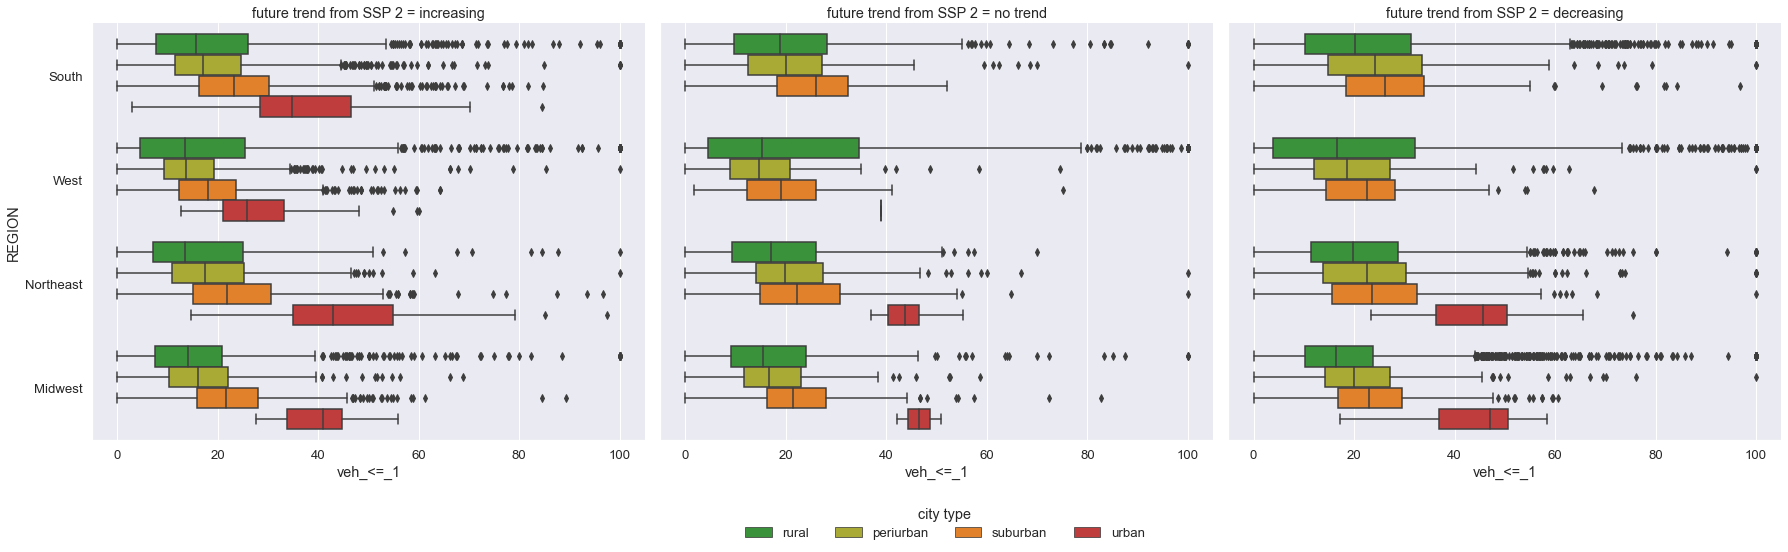

In [51]:
df['veh 1+'] = df['veh_2_or+'] + df['veh_1']
df['veh_<=_1'] = df['no_veh'] + df['veh_1']

df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
df_plot
trend_column = "future trend from SSP 2"
# sns.set(font_scale = 1.9)
g = sns.catplot(
    data=df_plot, x='veh_<=_1', y="REGION", hue = 'city type', col=trend_column,
    # order=['Northeast', 'Midwest', 'South', 'West'], 
    col_wrap =3,
    kind="box", 
    dodge = True, height=7, aspect= 1.2, 
    hue_order= ['rural', 'periurban', 'suburban', 'urban'],
    palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'], 
    col_order = ['increasing', 'no trend', 'decreasing']
)
sns.move_legend(g, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5, frameon=False)


In [52]:
df[['STATEFP', 'GEOID', 'NAMELSAD','weighted_HU_density_sqmi', 'P_20', 'label', 'density_km2',
       'Pop_estimate', 'CensusPop_20', 'trend', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 'REGION',
       'DIVISION', 'tt_2_work_place', 'no_veh', 'veh_1', 'veh_2_or+',
       'GEOID_place', 'GEOID_cbsa', 'cbsa20-to-place allocation factor',
       'tt_2_work', 'GEOID_', 'Urban area (2022)_count',
       'population_place_sum', 'ua-to-place allocation factor_min',
       'ua-to-place allocation factor_max', 'population_ua_min',
       'population_ua_max', 'city type', 'median_income', 'veh 1+',
       'veh_<=_1']].to_csv(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\df_attributes.csv')


In [53]:
# df['veh_<=_1'] = df['no_veh'] + df['veh_1']
# df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
# df_plot
# trend_column = "future trend from SSP 2"
# sns.set(font_scale = 1.5)
# g = sns.catplot(
#     data=df_plot, y="REGION", x='veh_<=_1', col=trend_column, hue = 'city type', col_wrap =3,
#     kind="box", height=7, aspect= 1.2, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
#     palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red']     
# )

# g.figure.savefig(r"D:\Work\Box Sync\Depop Forecasting Paper UF\Paper Draft US\Figures\Trend_SSP_3_vs_%veh_ownership.png", dpi = 300)

In [1]:
# df_plot[['future trend from SSP 2', 'REGION', 'city type', 'veh 1+', 'veh_<=_1']]


# sns.relplot(
#     data=df_plot, x='veh_<=_1', y='veh_2_or+',
#     col="REGION", hue="city type", style="future trend from SSP 2",
#     size ='density_km2',
#     sizes=(10, 500),
#     col_wrap = 2,
#     kind="scatter"
# )

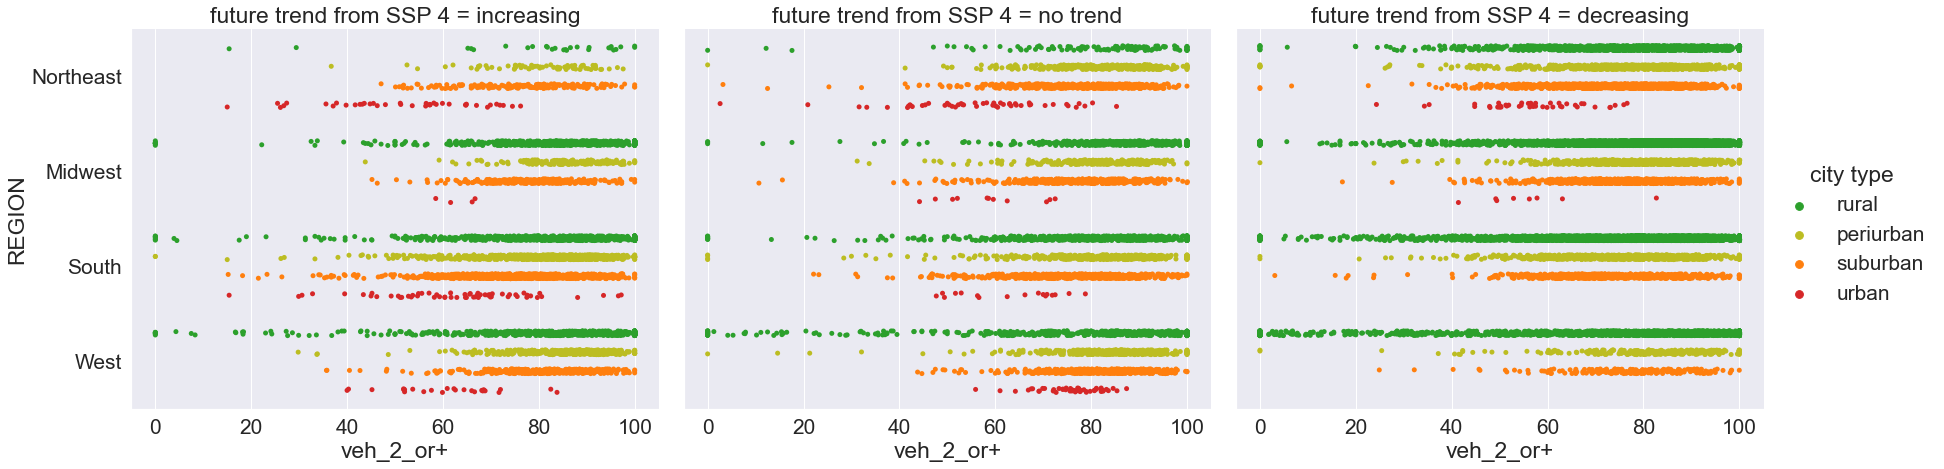

In [55]:
df_plot = df[(df['city type'] != 'not enough data') & (df['REGION'] != 'Outside Contiguous US')]
df_plot
trend_column = "future trend from SSP 4"
sns.set(font_scale = 1.9)
g = sns.catplot(
    data=df_plot, y="REGION", x='veh_2_or+', col=trend_column, hue = 'city type', col_wrap =3,
    order=['Northeast', 'Midwest', 'South', 'West'],
    kind="strip", dodge = True, height=7, aspect= 1.2, hue_order= ['rural', 'periurban', 'suburban', 'urban'],
    palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
    col_order = ['increasing', 'no trend', 'decreasing']
)


In [58]:
df_scatter = df[['median_income', 'CensusPop_20', 'density_km2', 'city type', 'REGION', 'future trend from SSP 2',]].dropna()
df_scatter = df_scatter[(df_scatter['REGION'] != 'Outside Contiguous US') & (df_scatter['density_km2'] < 15000)]
df_scatter['median income in thousands'] = df_scatter['median_income']/1000
df_scatter.dtypes

median_income                 float64
CensusPop_20                  float64
density_km2                   float64
city type                      object
REGION                         object
future trend from SSP 2        object
median income in thousands    float64
dtype: object

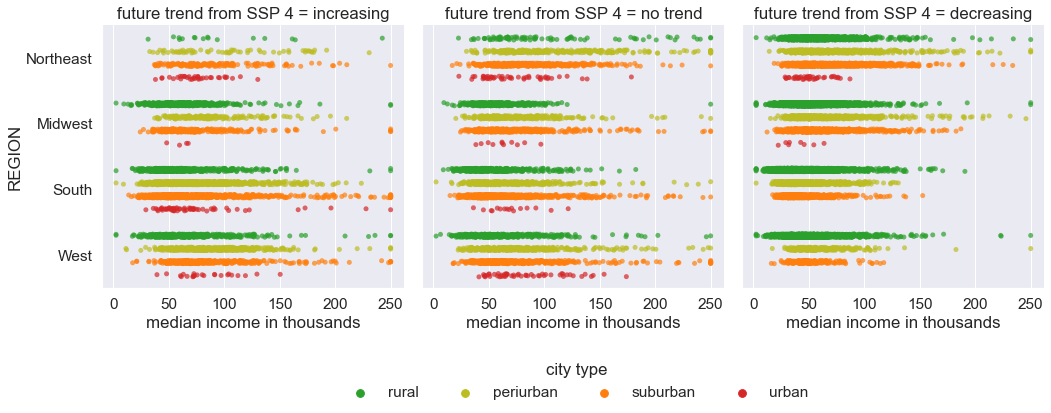

In [79]:
trend_col = 'future trend from SSP 4'
df_scatter = df[['median_income', 'CensusPop_20', 'density_km2', 'city type', 'REGION', trend_col,]].dropna()
df_scatter = df_scatter[(df_scatter['REGION'] != 'Outside Contiguous US') & (df_scatter['density_km2'] < 15000)]
df_scatter['median income in thousands'] = df_scatter['median_income']/1000
df_scatter.dtypes

sns.set(font_scale = 1.4)
g = sns.catplot(data=df_scatter, x='median income in thousands', y = 'REGION', alpha =0.7,
            order=['Northeast', 'Midwest', 'South', 'West'],
            col_order = ['increasing', 'no trend', 'decreasing'],
            hue_order= ['rural', 'periurban', 'suburban', 'urban'],
            palette = ['tab:green', 'tab:olive', 'tab:orange', 'tab:red'],
            hue="city type", dodge=True, col=trend_col,
           )

sns.move_legend(g, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5, frameon=False)
# plt.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.20),
#           fancybox=True, shadow=True, ncol=4)
plt.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\trend_vs_median_income' + str(trend_col) +'.png', 
            dpi =300, bbox_inches = 'tight')

In [61]:
df.groupby('future trend from SSP 2')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 2,,,,,,,,
decreasing,14377.0,318.48,348.20,0.0,89.11,226.02,428.67,5441.08
increasing,11642.0,752.15,1024.00,0.0,174.73,451.80,960.61,29930.29
no trend,2950.0,446.26,517.76,0.0,109.40,296.14,579.08,4624.83


In [62]:
df.groupby('label')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,968.0,95.25,217.52,0.00,8.98,32.13,97.84,2533.61
2 moderately depopulating,1853.0,266.93,444.54,0.00,68.64,156.61,304.12,11020.01
3 slowly depopulating,9017.0,488.99,695.20,0.00,117.61,303.83,589.09,29930.29
4 fluctuating,1479.0,336.99,438.05,0.04,82.75,205.83,415.91,4944.61
5 slowly increasing,5628.0,801.38,1021.51,0.12,246.26,490.73,1000.14,22572.24
6 moderately increasing,7298.0,542.49,712.31,0.01,158.55,350.34,661.81,16455.38
7 highly increasing,3002.0,356.92,556.35,0.03,60.59,179.66,434.65,7337.68


<AxesSubplot:>

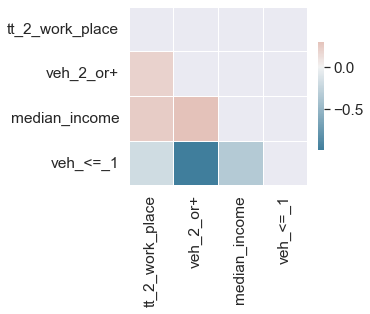

In [63]:
# Compute the correlation matrix
corr = df[['tt_2_work_place', 'veh_2_or+', 'median_income', 'veh_<=_1']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [64]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [65]:
X = df[['tt_2_work_place', 'veh_2_or+', 'median_income', 'veh_<=_1', 'city type']].dropna()

In [66]:
# 
# cat_idx = [4]
# kproto = KPrototypes(n_clusters=4, verbose=2, max_iter=20)
# kproto.fit(X, categorical=cat_idx)

# print(kproto.cluster_centroids_)

# clusters = kproto.predict(X, categorical=cat_idx)

In [ ]:
# clusters
# data_with_clusters = X.copy()
# data_with_clusters['Clusters'] = clusters
# plt.scatter(data_with_clusters.iloc[:,0],data_with_clusters.iloc[:,1],c=data_with_clusters['Clusters'],cmap='rainbow')

In [ ]:
X.dtypes

In [ ]:
import umap
from sklearn.preprocessing import PowerTransformer

#Preprocessing numerical
full_data = X
numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [ ]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)

In [ ]:
# fit1._raw_data

In [ ]:

embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False,
                                                densmap_kwds = {},
                                                output_dens = False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding[0].T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [ ]:
from kmodes.kprototypes import KPrototypes
kprot_data = full_data.copy()
#Pre-processing
for c in full_data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = [4] #make sure to specify correct indices

#Actual clustering
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(clusters).value_counts()

#OPTIONAL: Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 25)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [89]:
df.groupby('future trend from SSP 2')['CensusPop_20'].sum()
#/df.groupby('future trend from SSP 2')['CensusPop_20'].sum().sum()

future trend from SSP 2
decreasing     34549189.0
increasing    198544909.0
no trend       16414893.0
Name: CensusPop_20, dtype: float64

In [84]:
df.groupby('label')['CensusPop_20'].sum()/df.groupby('label')['CensusPop_20'].sum().sum()

label
1 severely depopulating      0.001089
2 moderately depopulating    0.005844
3 slowly depopulating        0.189456
4 fluctuating                0.006095
5 slowly increasing          0.393005
6 moderately increasing      0.370931
7 highly increasing          0.033580
Name: CensusPop_20, dtype: float64

# Adding landuse data from USGS LULC data

In [ ]:
# # Adding land use data to differentiatle between rural anb periurban
# # Change in land use in sqm
# LU_19 = pd.read_csv(r'D:\Work\Box Sync\Impervious Layer Quantification\Dataset\place_level_data\LandCoverbyCity19.csv')

# # Processing variables to combine similar ones together
# # converting sqm to sqkm
# LU_19['GEOID'] = LU_19['GEOID'].astype(str).str.rjust(7, "0")
# LU_19['totalLand'] = LU_19[['Perennial_ice_snow', 'Developed_open_space','Developed_low_intensity', 'Developed_medium_intensity',
#        'Developed_high_intensity', 'Barren_land', 'Deciduous_forest', 'Evergreen_forest', 'Mixed_forest', 'Dwarf_scrub', 'Shrub_scrub',
#        'Grassland_herbaceous', 'Sedge_herbaceous', 'Lichens', 'Moss', 'Pasture_hay', 'Cultivated_crops', 'Woody_wetland',
#        'EmergentherbaceousWetlands',]].sum(axis=1)

# LU_19['forest'] = LU_19[['Deciduous_forest','Evergreen_forest', 'Mixed_forest']].sum(axis=1) /LU_19['totalLand']
# LU_19['shrubLand'] = LU_19[['Dwarf_scrub', 'Shrub_scrub']].sum(axis=1)/LU_19['totalLand']
# LU_19['herbaceous'] = LU_19[['Grassland_herbaceous', 'Sedge_herbaceous', 'Lichens', 'Moss',]].sum(axis=1)/LU_19['totalLand']
# LU_19['wetLand'] = LU_19[['Woody_wetland','EmergentherbaceousWetlands']].sum(axis=1)/LU_19['totalLand']
# LU_19['barren'] = LU_19[['Barren_land']].sum(axis=1)/LU_19['totalLand']
# LU_19['planted/cultivated'] = LU_19[['Cultivated_crops', 'Pasture_hay']].sum(axis=1)/LU_19['totalLand']
# LU_19['builtArea'] = LU_19[['Developed_open_space', 'Developed_low_intensity', 'Developed_medium_intensity', 
#                             'Developed_high_intensity',]].sum(axis=1)/LU_19['totalLand']
# LU_19['builtHI'] = LU_19[['Developed_high_intensity',]].sum(axis=1)/LU_19['totalLand']
# LU_19['natural_vegitation'] = LU_19[['forest', 'shrubLand', 'herbaceous', 'wetLand']].sum(axis=1)

# # LU_19.columns
# df = df.merge(LU_19[['GEOID', 'totalLand','natural_vegitation', 'barren', 'planted/cultivated', 'builtArea', 'builtHI']], 
#            on = 'GEOID',
#            how = 'outer')


In [ ]:
# df[((df['class_LU'] == 'suburban') | (df['class_LU'] == 'periurban')) & (df['planted/cultivated'] > 0.5)][['GEOID','PCICBSA', 'NAMELSAD','weighted_HU_density_sqmi', 'density_km2', 'P_20', 
#                                     'tt_2_work_place', 'tt_2_work', 'class_LU','planted/cultivated', 'builtArea', 'builtHI']].sort_values(['planted/cultivated'])

In [ ]:
# df[(df['class_LU'] == 'rural') & (df['builtArea'] > 0.9)][['GEOID','PCICBSA', 'NAMELSAD','weighted_HU_density_sqmi', 'density_km2', 'P_20', 
#                                     'tt_2_work_place', 'tt_2_work', 'class_LU','planted/cultivated', 'builtArea', 'builtHI']].sort_values(['weighted_HU_density_sqmi','builtArea']).tail(20)

In [ ]:
# df.groupby(['REGION', 'class_LU'])[['class_LU', 'planted/cultivated', 'builtArea',]].describe()

In [59]:
#===============================================================================================================================#

In [ ]:
# ALL DRAFTS

In [ ]:
# # Adding MSA data to apply urban rural suburban conditions based on MSA population
# if places_US.crs == MSA_data.crs:
#     df_msa_overlayed = gpd.sjoin(places_US, MSA_data[MSA_data['LSAD']=='M1'], predicate = 'within') #.nunique()
#     #gpd.overlay(places_US, MSA_data, how='intersection')

# # df_msa_overlayed['GEOID_left'].nunique()
# df_msa = df_msa_overlayed[['GEOID_left','NAMELSAD_right', 'LSAD', 'msa_population', 'tt_2_work']]

In [ ]:
# df_xx = df.dropna()
# df_xx[['NAMELSAD', 'PCICBSA', 'weighted_HU_density', 'P_20', 
#        'NAMELSAD_2', 'msa_population',  'class_LU']].sort_values(['msa_population','weighted_HU_density'])
# # df_xx.columns

In [ ]:
# 45*100/32188, 1222*100/32188, 30921*100/32188
# 300*100/32188, 1161*100/32188, 30921*100/32188

In [296]:
# new_col = 'class_LU'
# population = 'P_20'
# housingUnit_density = 'weighted_HU_density'
# df = df0.copy()
# df[new_col] = " "

# # Apply conditions for urban-suburban-rural
# # source: https://bjs.ojp.gov/content/pub/pdf/cusrancvs.pdf
# for i in df.index:
#     if df.loc[i,'PCICBSA'] == 'Y':
#         if (df.loc[i, population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) | (
#             df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
#             df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
#             df.loc[i, new_col] = 'urban'
#         else:
#             df.loc[i, new_col] = 'suburban'
            
#     elif df.loc[i,'PCICBSA'] == 'N':
#         if (df.loc[i, population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) | (
#             df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
#             df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
#             df.loc[i, new_col] = 'urban'
#     # elif df[(df[population] >= 500000) & (df[housingUnit_density] >= 4000)]:
#     #     df[new_col] = 'urban'
#         else:
#             df.loc[i, new_col] = 'rural'

In [ ]:
# uac_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\CBSA data\ua_population.csv')

# uac_population.columns = uac_population.columns.str.strip()

# uac_population.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# uac_population['Urbanized Area Population'] = uac_population['Urbanized Area Population'].str.replace(',', '').astype(float)
# uac_population['Urbanized Area Population Density (ppsm)'] = uac_population['Urbanized Area Population Density (ppsm)'].str.replace(',', '').astype(float)

# uac_population_agg = uac_population.groupby('UACE').agg({'Urbanized Area Name':'first',
#                                    'Urbanized Area Population':'sum',
#                                    'Urbanized Area Land Area (sq. miles)':'sum',
#                                    'Urbanized Area Population Density (ppsm)':'sum',
#                                    }).reset_index()

# uac_population_agg['UACE'] = uac_population_agg['UACE'].astype(str).str.rjust(7, '0').str[:5]

# # urbanized areas and clusters
# US_uac10 = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2022_us_uac10.zip')
# US_uac10 = US_uac10.to_crs('EPSG:9311')

# # Urbanized area
# US_uac10_UA = US_uac10[US_uac10['LSAD10'] == '75'] 

# urbanizedAreaUS = US_uac10_UA.merge(uac_population_agg , left_on = 'UACE10', right_on = 'UACE')

# if places_US.crs != urbanizedAreaUS.crs:
#     urbanizedAreaUS = urbanizedAreaUS.to_crs('EPSG:9311') 
    
# df_uac_overlayed = places_US.overlay(urbanizedAreaUS, how = 'intersection')
# df_uac_overlayed['area_ratio'] = (df_uac_overlayed.area / df_uac_overlayed['ALAND']).round(3)

# df_uac_overlayed = df_uac_overlayed.sort_values('area_ratio', ascending = False)

# US_uac10 = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_uac20.zip')
# US_uac10 = US_uac10.to_crs('EPSG:9311')

# df_uac = df_uac_overlayed.groupby('GEOID').agg({'NAMELSAD10':'first',
#                                             'Urbanized Area Population':'first',
#                                             'Urbanized Area Population Density (ppsm)':'first',
#                                             'area_ratio': 'first'}).reset_index()

# df_uac_overlayed[df_uac_overlayed['GEOID'].duplicated(keep = False)][['GEOID','NAMELSAD', 'NAMELSAD10', 'Urbanized Area Population',
#        'Urbanized Area Population Density (ppsm)', 'area_ratio']].sort_values('area_ratio').head(210)

# df_uac[df_uac['area_ratio'] < .10].sort_values('area_ratio') #nunique()

In [ ]:

# # PLACES THAT HAVE LESS THAN 10000 POPULATION YET CLASIFIED AS URBAN
# # ===================================================================
# df[(df['class_LU'] == 'urban') & (df['P_20'] < 10000)][['NAMELSAD', 'density_km2','weighted_HU_density', 'P_20',
#                                                         'msa_population', 'Urbanized Area Population','State',
#                                                         'tt_2_work_place', 'tt_2_work','NAMELSAD10', 'area_ratio',
#                                                         'class_LU', 'builtArea',]].sort_values('P_20')

# # to check if the intersected areas fall inside the MSAs
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,14))
# # US_states.plot(ax=ax, facecolor = 'lightsteelblue', edgecolor='black', linewidth=0.2, alpha = 0.4)
# MSA_data[MSA_data['LSAD']=='M1'].plot(ax=ax, alpha = 0.4, color = 'darksalmon')
# # US_urban.plot(ax=ax, alpha = 0.4, edgecolor = 'red')
# # only metro areas 
# df.plot(ax= ax, column = 'class_LU', legend = True, legend_kwds={'loc': 'lower left'}, # [(df['class_LU'] == 'urban') & (df['P_20'] < 10000)]
#             cmap = matplotlib.colors.ListedColormap(['green','gold','brown',])) #  hatch='//'
# xlim = ([-2257388.37, 2695859.75]) 
# ylim = ([-2246944.04, 918095.9])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)


# # to check if the intersected areas fall inside the MSAs
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
# US_states.plot(ax=ax,facecolor = 'grey', edgecolor='black', linewidth=0.2, alpha = 0.4) #  facecolor = 'lightsteelblue', 
# MSA_data.plot(ax=ax, alpha = 0.3, color = 'darksalmon') # [MSA_data['LSAD']=='M1']
# # US_urban.plot(ax=ax, alpha = 0.4, edgecolor = 'red')
# # only metro areas 
# df[df['tt_2_work'].isnull()].plot(ax= ax, edgecolor = 'cyan', facecolor = 'none', linewidth=0.2, legend = True, legend_kwds={'loc': 'lower left'},) 
# df.plot(ax= ax, column = 'builtArea', cmap = 'RdYlGn_r', legend = True) 
# df[(df['class_LU'] == 'urban')].plot(ax= ax, edgecolor = 'maroon', facecolor = 'none', linewidth=0.3, legend = True, legend_kwds={'loc': 'lower left'},) 
# df[(df['class_LU'] == 'suburban')].plot(ax= ax, edgecolor = 'gold', facecolor = 'none', linewidth=0.2, legend = True, legend_kwds={'loc': 'lower left'},) 
# df_plot1.plot(ax= ax,  edgecolor = 'violet', facecolor = 'none', linewidth=0.1, legend = True, legend_kwds={'loc': 'lower left'},)
# df_plot2.plot(ax= ax,  edgecolor = 'blue', facecolor = 'none', linewidth=0.1, legend = True, legend_kwds={'loc': 'lower left'},)

# xlim = ([-2257388.37, 2695859.75]) 
# ylim = ([-2246944.04, 918095.9])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

# fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\Landuse with urban_.png', dpi = 600, bbox_inches='tight', transparent="True", pad_inches=0)


# df[(df['class_LU'] == 'rural')].plot(ax=ax, color = 'green')

# df[(df['class_LU'] == 'suburban') & (df['tt_2_work_place'] > df['tt_2_work'])].plot(ax=ax, color = 'cyan')

# df[(df['class_LU'] == 'suburban') & (df['tt_2_work_place'] <= df['tt_2_work'])].plot(ax=ax, color = 'goldenrod')

# # df[(df['class_LU'] == 'suburban') & (df['tt_2_work_place'] > df['tt_2_work'])].plot(ax=ax, color = 'cyan')
# # df[(df['class_LU'] == 'suburban') & (df['tt_2_work_place'] <= df['tt_2_work'])].plot(ax=ax, color = 'goldenrod')
# # df[(df['class_LU'] == 'periurban')].plot(ax=ax, color = 'cyan')

# # to check if the intersected areas fall inside the MSAs
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,7))

# metro_indicator = ['M1', 'M2']
# for ax, metro in zip(ax.flatten(), metro_indicator):
#     US_states.plot(ax=ax, facecolor = 'lightsteelblue', edgecolor='black', linewidth=0.2, alpha = 0.4)
#     MSA_data[MSA_data['LSAD']==metro].plot(ax=ax, alpha = 0.4, color = 'darksalmon') # only metro areas 
#     df.plot(ax= ax, column = 'class_LU',  legend = True, 
#             legend_kwds={'loc': 'lower left'},
#             cmap = matplotlib.colors.ListedColormap(['green','gold','brown',])) #  hatch='//'
#     xlim = ([-2257388.37, 2695859.75]) 
#     ylim = ([-2246944.04, 918095.9])
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
# # ax.set_facecolor('xkcd:ice') # https://xkcd.com/color/rgb/

# df[df['PCICBSA'] == 'N']['msa_population'].isna().sum()
# df[(df['msa_population'] > 0) & (df['portion_area'] > 0.5)].sort_values('portion_area')
# df_0[['STATEFP', 'GEOID', 'NAMELSAD', 'PCICBSA','weighted_HU_density', 'P_20', 'density_km2', 'State',
#        'NAME10', 'tt_2_work_place', 'tt_2_work', 'NAMELSAD_2', 'msa_population',]]
# MSA_data['tt_2_work'] = MSA_data['tt_2_work'].astype(float)
# # MSA_data.plot(column = 'tt_2_work',legend = True)
# # to check if the intersected areas fall inside the MSAs
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,7))

# metro_indicator = ['tt_2_work_place', 'tt_2_work']
# for ax, metro in zip(ax.flatten(), metro_indicator):
#     df_0.plot(ax =ax,  column = metro, legend = True)
#     xlim = ([-2257388.37, 2695859.75]) 
#     ylim = ([-2246944.04, 918095.9])
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)


# MSA_Population_20 = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Census Tract HUs\ACSDP5Y2020.DP05-Data.csv')
# MSA_Population =  MSA_Population_20[['GEO_ID', 'NAME', 'DP05_0001E']]
# MSA_Population = MSA_Population.iloc[1:,:].reset_index(drop= True)
# MSA_Population.rename({'DP05_0001E':'msa_population'}, axis =1, inplace = True)
# MSA_Population['GEOID'] = MSA_Population['GEO_ID'].str[9:]
# MSA_Population.columns
# MSA_geo_with_pop = MSA_geo_20.merge(MSA_Population[['msa_population', 'GEOID']], on = 'GEOID')
# # MSA_data.isna().sum()

# MSA_data.plot(column = 'tt_2_work')

In [ ]:
# # reading census data table with pandas
# def read_census_table(filepath, filename, list_of_columns, renamed_column_list, ):
#     df_original = pd.read_csv(filepath + filename+ '.csv')
#     df_selected = df_original[list_of_columns]
#     # dropping the first row with variable names
#     df_selected = df_selected.tail(-1).reset_index(drop = True)
#     df_selected.rename({'S0801_C01_046E':'tt_2_work_place'}, axis =1, inplace = True)
#     place_tt['GEOID'] = place_tt['GEO_ID'].str[9:]
    